Note: The errors are not due to syntactical/logical issues but due to memory constraints in colab. The code runs fine, expect on the last run, due to runtime timeouts, the code was not run

In [ ]:
# Run below commands
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
!tar xf spark-3.0.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [ ]:
## 4. Make sure envirnoment is set up to use Spark
import findspark
findspark.init()

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql import functions as F
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
from pyspark.sql import DataFrame
import random

In [ ]:
## Create a spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Venmo") \
    .getOrCreate()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:39639)
Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop3.2/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop3.2/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:39639)

In [35]:
# Read the Parquet file into a Spark DataFrame
df = spark.read.parquet('VenmoSample.snappy.parquet')

# Show the first few rows
df.show()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:39639)
Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop3.2/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop3.2/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:39639)

In [ ]:
df.dtypes

[('user1', 'int'),
 ('user2', 'int'),
 ('transaction_type', 'string'),
 ('datetime', 'timestamp'),
 ('description', 'string'),
 ('is_business', 'boolean'),
 ('story_id', 'string')]

In [ ]:
## Create a new date column
df = df.withColumn("date", to_date(col("datetime")))

In [ ]:
## Check the time range
min_max_values = df.agg(
    min(col("date")).alias("min_value"), max(col("date")).alias("max_value")
    ).collect()[0]
min_max_values["min_value"], min_max_values["max_value"]

(datetime.date(2011, 11, 29), datetime.date(2016, 12, 1))

In [ ]:
# Find the first transaction date for each user
user_start_date = df.groupBy("user1").agg(min(col("date")).alias("start_date"))

# Find the last transaction date for each user
user_end_date = df.groupBy("user1").agg(max(col("date")).alias("end_date"))

# Join the original DataFrame with the start dates and end dates DataFrame to get the start and end dates
df = df.join(user_start_date, on="user1", how="inner")
df = df.join(user_end_date, on="user1", how="inner")

df = df.withColumn("Lifetime", datediff(col("end_date"), col("start_date")))

In [ ]:
## Note: Assumption is that the users make payments every month, ontly such transactions are retained

# Retain customers who have been using app for >=12 months and retain transactions for the first 12 months only
df1 = df.filter(
    (year('start_date') == 2014) &
    (month('start_date') == 1) &
    (year('date') == 2015) &
    (month('date') == 1) &
    (col('transaction_type') == 'payment')
)

# Count transactions for each user within the first 12 months
transaction_counts = df1.groupBy("user1").agg(count("*").alias("transaction_count"))

df1 = df1.join(transaction_counts, on = "user1", how = "left")

df1.show(5)

+------+------+----------------+-------------------+--------------------+-----------+--------------------+----------+----------+----------+--------+-----------------+
| user1| user2|transaction_type|           datetime|         description|is_business|            story_id|      date|start_date|  end_date|Lifetime|transaction_count|
+------+------+----------------+-------------------+--------------------+-----------+--------------------+----------+----------+----------+--------+-----------------+
|292083|229804|         payment|2015-01-26 10:02:59|             Chinese|      false|54c5a053ca134c404...|2015-01-26|2014-01-19|2016-08-22|     946|                1|
|307303|203261|         payment|2015-01-08 00:40:54|       First payment|      false|54ad6198ca134c404...|2015-01-08|2014-01-15|2015-09-15|     608|                1|
|420077| 94309|         payment|2015-01-30 05:58:40|Random acts of no...|      false|54caad10ca134c404...|2015-01-30|2014-01-05|2016-05-29|     875|                1

In [ ]:
from pyspark.sql import functions as F

# Calculate months from the start date for each transaction
df1 = df1.withColumn("months_from_start", F.floor(F.months_between(F.col("date"), F.col("start_date"))))

# Group by user and months_from_start to calculate recency and frequency
rf_df = df1.groupBy("user1", "months_from_start").agg(
    F.max("date").alias("last_transaction_date"),
    F.count("*").alias("transaction_count")
)

# Calculate recency and frequency
rf_df = rf_df.withColumn("recency", 31 - F.dayofmonth("last_transaction_date")) ## Using 31 since some months have transaction on 31st day
rf_df = rf_df.withColumn("frequency", 30 / F.col("transaction_count"))

# Show the dataframe
rf_df.show()

+------+-----------------+---------------------+-----------------+-------+---------+
| user1|months_from_start|last_transaction_date|transaction_count|recency|frequency|
+------+-----------------+---------------------+-----------------+-------+---------+
|292083|               12|           2015-01-26|                1|      5|     30.0|
|307303|               11|           2015-01-08|                1|     23|     30.0|
|420077|               12|           2015-01-30|                1|      1|     30.0|
|424374|               11|           2015-01-04|                1|     27|     30.0|
|513523|               12|           2015-01-22|                1|      9|     30.0|
|806735|               12|           2015-01-27|                1|      4|     30.0|
|932765|               11|           2015-01-19|                1|     12|     30.0|
|339828|               11|           2015-01-02|                1|     29|     30.0|
|468215|               11|           2015-01-04|                1

In [ ]:
months_df = spark.range(0, 13).toDF("months_from_start")

# Get distinct users from the original DataFrame
users_df = df1.select("user1").distinct()

# Cross join to have all combinations of user1 and months_from_start
user_months_df = users_df.crossJoin(months_df)

# Left join with the recency-frequency DataFrame
rf_complete_df = user_months_df.join(rf_df, ["user1", "months_from_start"], "left")

# Fill in gaps where necessary, e.g., setting recency and frequency to null or a default value
rf_complete_df = rf_complete_df.fillna({"recency": "30", "frequency": "0"})

# Show the complete DataFrame
rf_complete_df.orderBy('user1').show()

In [ ]:
from pyspark.sql import functions as F

# Pivot the DataFrame for recency and frequency separately
recency_pivot = rf_complete_df.groupBy("user1").pivot("months_from_start").agg(
    F.first(F.col("recency")).alias("recency")
)

frequency_pivot = rf_complete_df.groupBy("user1").pivot("months_from_start").agg(
    F.first(F.col("frequency")).alias("frequency")
)

# Rename pivoted columns to indicate recency and frequency for each month
recency_pivot = recency_pivot.select(
    ["user1"] + [F.col(f"{c}").alias(f"recency_month_{c}") for c in recency_pivot.columns if c != 'user1']
)
frequency_pivot = frequency_pivot.select(
    ["user1"] + [F.col(f"{c}").alias(f"frequency_month_{c}") for c in frequency_pivot.columns if c != 'user1']
)

# Join the pivoted recency and frequency DataFrames back with the original DataFrame
df1 = df1.join(recency_pivot, "user1", "left")
df1 = df1.join(frequency_pivot, "user1", "left")

# Show the DataFrame to confirm the join
df1.orderBy('transaction_count', ascending = False).show()

+------+-------+----------------+-------------------+--------------------+-----------+--------------------+----------+----------+----------+--------+-----------------+-----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+
| user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|      date|start_date|  end_date|Lifetime|transaction_count|months_from_start|recency_month_0|recency_month_1|recency_month_2|recency_month_3|recency_month_4|recency_month_5|recency_month_6|recency_month_7|recency_month_8|recency_month_9|recency_month_10|rece

In [ ]:
## Retain unique users

df_rf = df1.groupBy("user1").agg(
    F.first("transaction_count").alias("transaction_count"),
    *(F.first(F.col(f"recency_month_{i}")).alias(f"recency_month_{i}") for i in range(13)),
    *(F.first(F.col(f"frequency_month_{i}")).alias(f"frequency_month_{i}") for i in range(13))
)

# Display the DataFrame to check it's structured as expected
df_rf.show(5)

+------+-----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+
| user1|transaction_count|recency_month_0|recency_month_1|recency_month_2|recency_month_3|recency_month_4|recency_month_5|recency_month_6|recency_month_7|recency_month_8|recency_month_9|recency_month_10|recency_month_11|recency_month_12|frequency_month_0|frequency_month_1|frequency_month_2|frequency_month_3|frequency_month_4|frequency_month_5|frequency_month_6|frequency_month_7|frequency_month_8|frequency_month_9|frequency_month_10|frequency_month_11|frequency_month_12|
+------+-----------------+---------------+--------

Q9 For each user’s lifetime point, regress recency and frequency on Y. Plot the MSE
for each lifetime point.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluator for calculating MSE
evaluator = RegressionEvaluator(labelCol = "transaction_count", predictionCol = "prediction", metricName = "mse")

mse_results = []

for month in range(13):
    # Assemble features for the current month
    assembler = VectorAssembler(
        inputCols = [f"recency_month_{month}", f"frequency_month_{month}"],
        outputCol = "features"
    )

    # Transform the data frame to include feature vectors
    transformed_df = assembler.transform(df_rf).select("features", "transaction_count")

    # Split the data into training and testing sets
    train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed = 1)

    # Define the linear regression model
    lm = LinearRegression(featuresCol = "features", labelCol="transaction_count")

    # Fit the model on training data
    lm_model = lm.fit(train_data)

    # Predict on test data
    predictions = lm_model.transform(test_data)

    # Calculate MSE and store along with the month
    mse = evaluator.evaluate(predictions)
    mse_results.append((month, mse))

# Convert the results into a DataFrame for easier handling
mse_df = spark.createDataFrame(mse_results, ["Month", "MSE"])
mse_df.show()

+-----+-------------------+
|Month|                MSE|
+-----+-------------------+
|    0|0.15126405884700997|
|    1|0.15126405884700997|
|    2|0.15126405884700997|
|    3|0.15126405884700997|
|    4|0.15126405884700997|
|    5|0.15126405884700997|
|    6|0.15126405884700997|
|    7|0.15126405884700997|
|    8|0.15126405884700997|
|    9|0.15126405884700997|
|   10|0.15126405884700997|
|   11|0.21731126993825062|
|   12|0.14209596583163547|
+-----+-------------------+



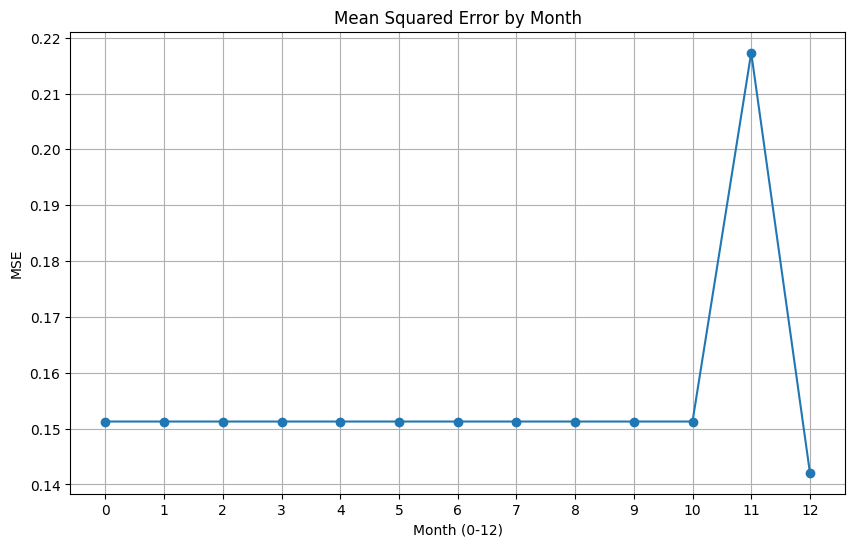

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
mse_pd = mse_df.toPandas()

# Plotting the MSE for each month
plt.figure(figsize=(10, 6))
plt.plot(mse_pd['Month'], mse_pd['MSE'], marker='o')
plt.title('Mean Squared Error by Month')
plt.xlabel('Month (0-12)')
plt.ylabel('MSE')
plt.xticks(range(0, 13))
plt.grid(True)
plt.show()

Q10 For each user’s lifetime point, regress recency, frequency AND her spending
behavior profile on Y.

In [ ]:
# Function to load and transform emoji and text dictionaries
def load_transform_dict(file_path, categories):
    df = spark.read.csv(file_path, header=True)
    # Convert the DataFrame of categories into a long format
    transformed_df = df.select([explode(array([(col(c), lit(c)) for c in categories])).alias("pair")])
    return transformed_df.select(col("pair._1").alias("word"), col("pair._2").alias("category"))


categories = ["People", "Food", "Event", "Activity", "Travel", "Transportation", "Utility", "Cash", "Illegal/Sarcasm"]

# Load and transform both dictionaries
emoji_dict_df = load_transform_dict("emoji_csv.csv", categories)
text_dict_df = load_transform_dict("text_csv.csv", categories)

# Combine the dictionaries
classification_df = emoji_dict_df.union(text_dict_df)
classification_df.show()

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Broadcast the classification dictionary
classification_dict = spark.sparkContext.broadcast(classification_df.collect())

# Function to classify descriptions
def classify(description):
    description = description.lower()
    for entry in classification_dict.value:
        if entry.word in description:
            return entry.category
    return "other"


classify_udf = udf(classify, StringType())

# Classify transactions
transactions_df = df.withColumn("category", classify_udf(col("description")))
transactions_df.show()

In [ ]:
# Calculate the number of transactions per category per user
category_count_df = transactions_df.groupBy("user1", "category").count()

# Total transactions per user
total_transactions_df = transactions_df.groupBy("user1").count().withColumnRenamed("count", "total_transactions")

# Join and calculate percentages
profile_df = category_count_df.join(total_transactions_df, "user1")
profile_df = profile_df.withColumn("percentage", col("count") / col("total_transactions") * 100)

# Pivot to get a spending profile for each user
spending_profile_df = profile_df.groupBy("user1").pivot("category").max("percentage").fillna(0)
spending_profile_df.show()

In [ ]:
## Combine dataframes on RF metrics and spending profiles
model_df = df_rf.join(spending_profile_df, transactions_df.user1 == spending_profile_df.user1)

model_df.show()

In [ ]:
# Initialize evaluator for calculating MSE
evaluator = RegressionEvaluator(labelCol = "transaction_count", predictionCol = "prediction", metricName = "mse")

mse_results = []

for month in range(13):
    # Assemble features for the current month
    assembler = VectorAssembler(
        inputCols = [f"recency_month_{month}", f"frequency_month_{month}", "category"],
        outputCol = "features"
    )

    # Transform the data frame to include feature vectors
    transformed_df = assembler.transform(df_rf).select("features", "transaction_count")

    # Split the data into training and testing sets
    train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed = 1)

    # Define the linear regression model
    lm = LinearRegression(featuresCol = "features", labelCol="transaction_count")

    # Fit the model on training data
    lm_model = lm.fit(train_data)

    # Predict on test data
    predictions = lm_model.transform(test_data)

    # Calculate MSE and store along with the month
    mse = evaluator.evaluate(predictions)
    mse_results.append((month, mse))

# Convert the results into a DataFrame for easier handling
mse_df = spark.createDataFrame(mse_results, ["Month", "MSE"])

# Convert the Spark DataFrame to a Pandas DataFrame
mse_pd = mse_df.toPandas()

# Plotting the MSE for each month
plt.figure(figsize=(10, 6))
plt.plot(mse_pd['Month'], mse_pd['MSE'], marker='o')
plt.title('Mean Squared Error by Month')
plt.xlabel('Month (0-12)')
plt.ylabel('MSE')
plt.xticks(range(0, 13))
plt.grid(True)
plt.show()

Since majority of the transactions happen towards the end of the lifetime, (in this case), we see that using spending behaviour provides a slight improvement to the MSE. i.e it adds to the predictive power

Q11 For each user’s lifetime point, regress her social network metrics on Y. Plot the
MSE for each lifetime point like above.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, countDistinct, min, months_between
from pyspark.sql import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Convert datetime to timestamp
df = df.withColumn("datetime", col("datetime").cast("timestamp"))

# Sample a subset of the data (e.g., 10% of the original data)
sample_fraction = 0.00001
sampled_df = df.sample(fraction=sample_fraction, seed=42)

# Step 1: Filter Transactions for the First 12 Months from the First Transaction
window_spec = Window.partitionBy("user1").orderBy("datetime")
sampled_df = sampled_df.withColumn("first_transaction_date", min("datetime").over(window_spec))
sampled_df = sampled_df.withColumn("months_since_first", expr("months_between(datetime, first_transaction_date)"))

# Filter out transactions outside the first 12 months
sampled_df = sampled_df.filter(col("months_since_first") <= 12)

# Step 2: Calculate Social Network Metrics
# Identify direct friends
direct_friends_df = sampled_df.select(col("user1").alias("user"), col("user2").alias("friend")) \
    .union(sampled_df.select(col("user2").alias("user"), col("user1").alias("friend")))

# Identify second-degree friends (friends of friends)
second_degree_friends_df = direct_friends_df.alias("df1") \
    .join(direct_friends_df.alias("df2"), col("df1.friend") == col("df2.user")) \
    .select(col("df1.user").alias("user"), col("df2.friend").alias("second_degree_friend")) \
    .filter(col("df1.user") != col("df2.friend")) \
    .distinct()

# Count the number of friends for each user
friends_count_df = direct_friends_df.groupBy("user").agg(countDistinct("friend").alias("num_friends"))

# Count the number of second-degree friends for each user
second_degree_friends_count_df = second_degree_friends_df.groupBy("user").agg(countDistinct("second_degree_friend").alias("num_second_degree_friends"))

# Combine the counts
user_stats_df = friends_count_df.join(second_degree_friends_count_df, "user", "left").na.fill(0)

# Rename columns to avoid conflicts when joining back to the original DataFrame
user_stats_df = user_stats_df.withColumnRenamed("user", "user_id")

# Join the counts back to the original transactions DataFrame for user1
sampled_df = sampled_df.join(
    user_stats_df.withColumnRenamed("user_id", "user1")
    .withColumnRenamed("num_friends", "user1_num_friends")
    .withColumnRenamed("num_second_degree_friends", "user1_num_second_degree_friends"),
    "user1",
    "left"
)

# Join the counts back to the original transactions DataFrame for user2
sampled_df = sampled_df.join(
    user_stats_df.withColumnRenamed("user_id", "user2")
    .withColumnRenamed("num_friends", "user2_num_friends")
    .withColumnRenamed("num_second_degree_friends", "user2_num_second_degree_friends"),
    "user2",
    "left"
)

# Fill null values with 0
sampled_df = sampled_df.fillna(0, subset=[
    "user1_num_friends",
    "user1_num_second_degree_friends",
    "user2_num_friends",
    "user2_num_second_degree_friends"
])

# Step 3: Regress Social Network Metrics on Y
mse_list = []

for month in range(13):
    # Filter data for the current month
    month_df = sampled_df.filter(col("months_since_first") == month)

    if month_df.count() == 0:
        continue

    # Prepare data for regression
    assembler = VectorAssembler(inputCols=["user1_num_friends", "user1_num_second_degree_friends"], outputCol="features")
    assembled_df = assembler.transform(month_df)

    # Define the linear regression model
    lm = LinearRegression(featuresCol="features", labelCol="Y")

    # Fit the model
    lm_model = lm.fit(assembled_df)

    # Make predictions
    predictions = lm_model.transform(assembled_df)

    # Calculate MSE
    mse = predictions.selectExpr("POWER(Y - prediction, 2) as squared_error").agg({"squared_error": "mean"}).collect()[0][0]
    mse_list.append((month, mse))

# Convert MSE list to DataFrame
mse_df = pd.DataFrame(mse_list, columns=["Month", "MSE"])

# Step 4: Plot MSE
plt.figure(figsize=(10, 6))
plt.plot(mse_df["Month"], mse_df["MSE"], marker='o')
plt.title("Mean Squared Error (MSE) over User Lifetime")
plt.xlabel("Months Since First Transaction")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop3.2/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop3.2/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.0.3-bin-hadoop3.2/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o837.select

The social network metrics in this case are a better predictor as observed and it makes sense because a user's total transactions will be dependent on the size of the social nework i.e friends, firneds of friends etc. the larger the social network indicated, the more the transactions. The results are better than the RF framework mainly due to the following reasons:

- It could be observed that in our selected timeframe, many users have frequency of 0 and recency of 30 indicating very less usage across months.
- We also spsrseness of usage.

Hence, it makes sense that the RF metrics would not be too good at capturing the transaction patterns

Q12 For each user’s lifetime point, regress her social network metrics and the
spending behavior of her social network on Y

In [ ]:
from pyspark.sql.functions import col, collect_set, size, explode

# Determine direct friends
friends_df = df.selectExpr("user1 as user", "user2 as friend").distinct()

# Determine friends of friends (excluding direct friends and self-loops)
fof_df = friends_df.alias("df1").join(friends_df.alias("df2"), col("df1.friend") == col("df2.user")) \
    .select(col("df1.user"), col("df2.friend").alias("fof")) \
    .where("df1.user != df2.friend and df1.user != df2.user")

# Aggregate counts of friends and fofs
network_metrics_df = friends_df.groupBy("user").agg(size(collect_set("friend")).alias("num_friends"))
fof_metrics_df = fof_df.groupBy("user").agg(size(collect_set("fof")).alias("num_fofs"))

# Join the metrics
network_metrics_df = network_metrics_df.join(fof_metrics_df, "user", "outer").fillna(0)

# Join the spending profile with friends
friend_spending_df = friends_df.join(spending_profile_df, friends_df.friend == spending_profile_df.user1)

# Aggregate the average spending percentage of friends per category
avg_friend_spending_df = friend_spending_df.groupBy("user").pivot("category").agg(F.avg("percentage"))

# Join network metrics with average spending behavior
network_metrics_df = network_metrics_df.join(avg_friend_spending_df, "user")

model_data_df = df_rf.join(network_metrics_df, df_rf.user1 == network_metrics_df.user)

for month in range(13):
    # Assemble features for the current month
    assembler = VectorAssembler(
        inputCols = [f"recency_month_{month}", f"frequency_month_{month}", "category"],
        outputCol = "features"
    )

    # Transform the data frame to include feature vectors
    transformed_df = assembler.transform(df_rf).select("features", "transaction_count")

    # Split the data into training and testing sets
    train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed = 1)

    # Define the linear regression model
    lm = LinearRegression(featuresCol = "features", labelCol="transaction_count")

    # Fit the model on training data
    lm_model = lm.fit(train_data)

    # Predict on test data
    predictions = lm_model.transform(test_data)

    # Calculate MSE and store along with the month
    mse = evaluator.evaluate(predictions)
    mse_results.append((month, mse))

# Convert the results into a DataFrame for easier handling
mse_df = spark.createDataFrame(mse_results, ["Month", "MSE"])

# Convert the Spark DataFrame to a Pandas DataFrame
mse_pd = mse_df.toPandas()

# Plotting the MSE for each month
plt.figure(figsize=(10, 6))
plt.plot(mse_pd['Month'], mse_pd['MSE'], marker='o')
plt.title('Mean Squared Error by Month')
plt.xlabel('Month (0-12)')
plt.ylabel('MSE')
plt.xticks(range(0, 13))
plt.grid(True)
plt.show()


Unable do draw conclusions due to memory constraints